# Introduction
In my project I will explore the ratio of human and animal hospitals in big and small (by population) cities. The hypothesis is that people in largely populated cities have more pets and will have relatively more veterinarian hospitals in relation to human hospitals compared to smaller cities. This information could be used to decide if it is viable to start a pet related business in an area depending on the human/animal hospital ratio.

# Data
In this project I will use Foursquare data to get a list of hospitals (human and animal) in a 100km radius of center of the city. Because Foursquare API can only give up to 50 results in a given area, the results need to be filtered by the desired city. Cities will be chosen by their population data, which will be scraped from wikipedia.

# Methodology
Hospital data is requested from Foursquare API and then hospitals and veterinary hospitals are counted for each city. Results are plotted on scatter plots with regression lines. Main objective is to determine if bigger city population has effect on hospital/veterinary hospital ratio. As an extra analysis, hospital/veterinary hospital ratios are plotted against longitude an latitude, to see if geographic location has any effect on these ratios.

# Results

In [1]:
!pip install folium==0.5.0
!pip install geopy
import requests
import pandas as pd
import numpy as np
import random 
import folium
import time
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize

print('Libraries imported.')

Libraries imported.


In [2]:
# The code was removed by Watson Studio for sharing.

In [4]:
address_list = [
    "New York, New York",
    "Los Angeles, California",
    "Chicago, Illinois",
    "Houston, Texas",
    "Phoenix, Arizona",
    "Philadelphia, Pennsylvania",
    "Seattle, Washington",
    "Detroit, Michigan",
    "Portland, Oregon",
    "Las Vegas, Nevada",
    "Omaha, Nebraska",
    "Anchorage, Alaska",
    "Sioux Falls, South Dakota",
    "Bridgeport, Connecticut",
    "Charleston, South Carolina",
    "Manchester, New Hampshire",
    "Billings, Montana"
]
population_data = {
    "City" : address_list,
    "Population" : [
        8336817,
        3979576,
        2693976,
        2320268,
        1680992,
        1584064,
        753675,
        670031,
        654741,
        651319,
        478192,
        288000,
        183793,
        144399,
        137566,
        112673,
        109577
    ]
}
result_list = []
latitude_list = []
longitude_list = []
for address in address_list:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    latitude_list.append(latitude)
    longitude_list.append(longitude)
    #print(latitude, longitude)
    search_query = 'Hospital'
    radius = 100000
    #print(search_query + ' .... OK!')
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
    attempts = 0
    tries = 5
    while attempts < tries:
        result = requests.get(url).json()
        if "server_error" in result:
            attempts = attempts + 1
            time.sleep(1)
        else:
            result_list.append(result)
            break
    if attempts == tries:
        print("Foursquare server error!")
location_dict = {
    "Latitude" : latitude_list,
    "Longitude" : longitude_list
}

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
hospital_list = []
veterinarian_list = []
for results in result_list:
    try:
        venues = results['response']['venues']
        dataframe = pd.json_normalize(venues)
        filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
        dataframe_filtered = dataframe.loc[:, filtered_columns]
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
        localized_dataframe = dataframe_filtered[dataframe_filtered["city"] == dataframe_filtered['city'][1]]
        
        category_dict = localized_dataframe['categories'].value_counts().to_dict()
        if "Hospital" in category_dict:
            hospital_list.append(category_dict["Hospital"])
        else:
            hospital_list.append(0)

        if "Veterinarian" in category_dict:
            veterinarian_list.append(category_dict["Veterinarian"])
        else:
            veterinarian_list.append(0)
        
        #print(localized_dataframe['city'][1] + " entry done!")
    except:
        print("Foursquare servers busy!")
        hospital_list.append(0)
        veterinarian_list.append(0)
hospital_dict = {
    "Hospitals" : hospital_list,
    "Veterinarian" : veterinarian_list
}
#print(hospital_list)
#print(veterinarian_list)

In [7]:
location_dict.update(hospital_dict)
population_data.update(location_dict)
data_table = pd.DataFrame.from_dict(population_data)
data_table
data_table['Hospital ratio'] = data_table["Hospitals"]/(data_table["Hospitals"] + data_table["Veterinarian"])
data_table['Veterinarian ratio'] = data_table["Veterinarian"]/(data_table["Hospitals"] + data_table["Veterinarian"])
data_table

,City,Population,Latitude,Longitude,Hospitals,Veterinarian,Hospital ratio,Veterinarian ratio
0,"New York, New York",8336817,40.712728,-74.006015,13,11,0.541667,0.458333
1,"Los Angeles, California",3979576,34.053691,-118.242766,11,7,0.611111,0.388889
2,"Chicago, Illinois",2693976,41.875562,-87.624421,21,5,0.807692,0.192308
3,"Houston, Texas",2320268,29.758938,-95.367697,22,5,0.814815,0.185185
4,"Phoenix, Arizona",1680992,33.448437,-112.074142,14,7,0.666667,0.333333
5,"Philadelphia, Pennsylvania",1584064,39.952724,-75.163526,21,5,0.807692,0.192308
6,"Seattle, Washington",753675,47.603832,-122.330062,6,9,0.400000,0.600000
7,"Detroit, Michigan",670031,42.331551,-83.046640,11,0,1.000000,0.000000
8,"Portland, Oregon",654741,45.520247,-122.674195,7,19,0.269231,0.730769
9,"Las Vegas, Nevada",651319,36.167256,-115.148516,14,9,0.608696,0.391304


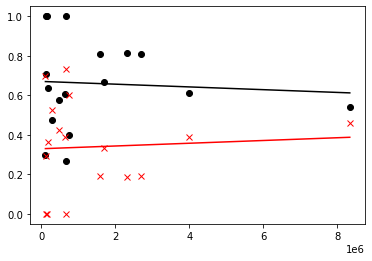

In [8]:
plt.plot(data_table["Population"], data_table["Hospital ratio"], 'o', color='black');
plt.plot(data_table["Population"], data_table["Veterinarian ratio"], 'x', color='red');
m, b = np.polyfit(data_table["Population"], data_table["Hospital ratio"], 1)
plt.plot(data_table["Population"], m*data_table["Population"] + b, color='black')
m, b = np.polyfit(data_table["Population"], data_table["Veterinarian ratio"], 1)
plt.plot(data_table["Population"], m*data_table["Population"] + b, color='red')

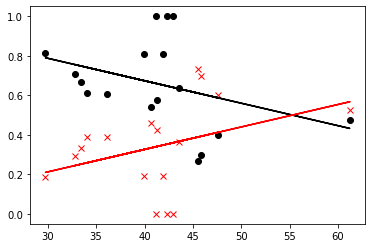

In [9]:
plt.plot(data_table["Latitude"], data_table["Hospital ratio"], 'o', color='black');
plt.plot(data_table["Latitude"], data_table["Veterinarian ratio"], 'x', color='red');
m, b = np.polyfit(data_table["Latitude"], data_table["Hospital ratio"], 1)
plt.plot(data_table["Latitude"], m*data_table["Latitude"] + b, color='black')
m, b = np.polyfit(data_table["Latitude"], data_table["Veterinarian ratio"], 1)
plt.plot(data_table["Latitude"], m*data_table["Latitude"] + b, color='red')

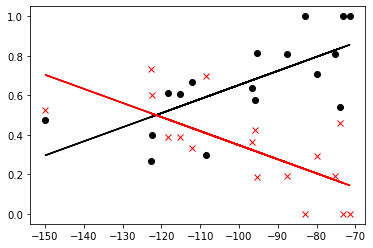

In [10]:
plt.plot(data_table["Longitude"], data_table["Hospital ratio"], 'o', color='black');
plt.plot(data_table["Longitude"], data_table["Veterinarian ratio"], 'x', color='red');
m, b = np.polyfit(data_table["Longitude"], data_table["Hospital ratio"], 1)
plt.plot(data_table["Longitude"], m*data_table["Longitude"] + b, color='black')
m, b = np.polyfit(data_table["Longitude"], data_table["Veterinarian ratio"], 1)
plt.plot(data_table["Longitude"], m*data_table["Longitude"] + b, color='red')